# Decodability (as in Taku's paper)

Symmetrize RSM matrices and then find if diagonal has value higher than rest of the row

In [1]:
import pickle
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
# from sklearn import metrics as skm
import statsmodels.api as sm

import wbplot
import matplotlib.image as img
import matplotlib.colors as clrs
from matplotlib import colorbar

# import RSMtools
import plottools

from tqdm import tqdm

from brainsmash.mapgen.base import Base
from brainsmash.mapgen.stats import pearsonr, pairwise_r
from brainsmash.mapgen.stats import nonparp

In [2]:
projdir = '/home/ln275/f_mc1689_1/multitask_generalization/'
subProjDir = projdir + 'data/derivatives/RSM_ActFlow/'
surfaceDeriv_dir = projdir + 'data/derivatives/surface/'
helpfiles_dir = projdir + 'docs/experimentfiles/'
figoutdir = projdir + 'docs/figures/working/vertexwiseFC/'
fcdir = projdir + 'data/derivatives/FC_new/'

In [3]:
subIDs=['02','03','06','08','10','12','14','18','20',
        '22','24','25','26','27','28','29','30','31']

onlyRestSubIdx = [ 0, 1, 3, 4, 6, 7, 8,10,11,
                  12,20,13,21,14,22,15,23,16] # Use when dealing with full subjects' data (n=24)

nSub = len(subIDs)
nParcels = 360
nVertices = 59412
nSessions = 2

nTask = 16
nTaskCond_presensorimotor = 32
nTaskCond = 96

glasserfilename = helpfiles_dir + 'Q1-Q6_RelatedParcellation210.LR.CorticalAreas_dil_Colors.32k_fs_RL.dlabel.nii'

glasser = np.squeeze(nib.load(glasserfilename).get_fdata())

networkdef = np.loadtxt(helpfiles_dir + 'cortex_parcel_network_assignments.txt')
networkNames = ['VIS1','VIS2','SMN','CON','DAN','LAN','FPN','AUD','DMN','PMULTI','VMM','ORA']

In [4]:
# Computing RSM based decodability:

with open(subProjDir + 'allsub_taskCond_tasksplit_RSM_activeVisual.pkl', 'rb') as f:
        allsub_taskCondRSM_tasksplit = pickle.load(f)
    
# with open(subProjDir + 'allsub_taskCond_presensorimotor_RSM_activeVisual.pkl', 'rb') as f:
#         allsub_taskCondRSM_presensorimotor = pickle.load(f)

with open(subProjDir + 'allsub_taskCond_RSM_activeVisual.pkl', 'rb') as f:
    allsub_taskCondRSM = pickle.load(f)
    
print('allsub_taskCondRSM_tasksplit shape:',allsub_taskCondRSM_tasksplit.shape)
# print('allsub_taskCondRSM_presensorimotor shape:',allsub_taskCondRSM_presensorimotor.shape)
print('allsub_taskCondRSM shape:',allsub_taskCondRSM.shape)

allsub_taskCondRSM_tasksplit shape: (24, 360, 16, 16)
allsub_taskCondRSM shape: (24, 360, 96, 96)


In [5]:
select_sub_taskCondRSM_tasksplit = allsub_taskCondRSM_tasksplit[onlyRestSubIdx,:,:,:] # rest data's available only for 18 sub
# select_sub_taskCondRSM_presensorimotor = allsub_taskCondRSM_presensorimotor[onlyRestSubIdx,:,:,:]
select_sub_taskCondRSM = allsub_taskCondRSM[onlyRestSubIdx,:,:,:]

print('select_sub_taskCondRSM_tasksplit shape:', select_sub_taskCondRSM_tasksplit.shape)
# print('select_sub_taskCondRSM_presensorimotor shape:', select_sub_taskCondRSM_presensorimotor.shape)
print('select_sub_taskCondRSM shape:', select_sub_taskCondRSM.shape)

select_sub_taskCondRSM_tasksplit shape: (18, 360, 16, 16)
select_sub_taskCondRSM shape: (18, 360, 96, 96)


In [6]:
def get_decodability(meansub_RSM, size):

    '''
    returns: decodability: shape: (nParcels,nTaskCond or equivalent based on RSM size)
    '''
    
    decodability = np.zeros((nParcels,size))

    for reg_idx in range(nParcels):
        this_reg_RSM = meansub_RSM[reg_idx,:,:]

        for idx in range(size):
            if np.argmax(this_reg_RSM[idx,:]) == idx:
                decodability[reg_idx,idx] = 1
            else:
                decodability[reg_idx,idx] = 0
                
    return decodability

In [7]:
def compute_decodability(selectRSM,size):

    selectRSM_sym = np.zeros((nSub,nParcels,size,size))

    for sub_idx in range(nSub):
        for reg_idx in range(nParcels):
            this_RSM = selectRSM[sub_idx,reg_idx,:,:]
            this_RSM_symmetrized = (this_RSM + this_RSM.T)/2

            selectRSM_sym[sub_idx,reg_idx,:,:] = this_RSM_symmetrized

    meansub_RSM = np.mean(selectRSM_sym,axis=0)
    decodability = get_decodability(meansub_RSM, size=size)

    return decodability

In [8]:
tasksplit_decodability = compute_decodability(selectRSM=select_sub_taskCondRSM_tasksplit,size=nTask)
# taskCond_presensorimotor_decodability = compute_decodability(selectRSM=select_sub_taskCondRSM_presensorimotor,
                                                             # size=nTaskCond_presensorimotor)
taskCond_decodability = compute_decodability(selectRSM=select_sub_taskCondRSM,size=nTaskCond)

<Axes: >

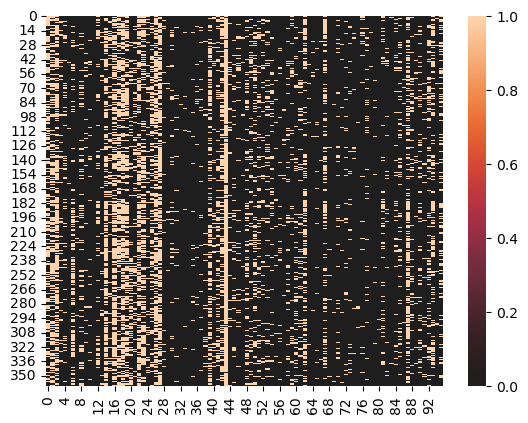

In [9]:
sns.heatmap(taskCond_decodability,center=0)

In [9]:
mean_taskCond_decodability = np.mean(taskCond_decodability,axis=1)
mean_tasksplit_decodability = np.mean(tasksplit_decodability,axis=1)

In [11]:
# Brain plot: Move to utils later

def get_brain_plot(inputdata,file_out,title,ignore_zero=False):

    #flip hemispheres, since CAB-NP is ordered left-to-right, while wbplot uses right-to-left
    inputdata_flipped=np.zeros(np.shape(inputdata))
    inputdata_flipped[0:180]=inputdata[180:360]
    inputdata_flipped[180:360]=inputdata[0:180]

    if ignore_zero:
        non_zero_mask = inputdata != 0
        min_inputdata = np.min(inputdata[non_zero_mask])
    else:
        min_inputdata = np.min(inputdata)
    
    # Set to all reds if no negative values
    if min_inputdata >= 0:
        colormap='Reds'
        vmin, vmax = min_inputdata, np.max(inputdata)
    else:
        colormap='seismic'
        limit = np.max([np.abs(min_inputdata), np.abs(np.max(inputdata))])
        vmin,vmax = -1*limit, limit

    wbplot.pscalar(
            file_out=figoutdir + file_out + '.png',
            pscalars=inputdata_flipped,
            vrange = (vmin,vmax),
            cmap=colormap,
            transparent=True)

    plt.figure(figsize=(3.5,3))
    ax = plt.subplot(111)
    im = img.imread(figoutdir + file_out + '.png') 
    plt.imshow(im)
    plt.axis('off')
    plt.title(title,fontsize=18)

    # vmin, vmax = -2, 2
    cnorm = clrs.Normalize(vmin=vmin, vmax=vmax)  # only important for tick placing
    cmap = plt.get_cmap(colormap)
    cax = ax.inset_axes([0.44, 0.48, 0.12, 0.07])
    cbar = colorbar.ColorbarBase(
        cax, cmap=cmap, norm=cnorm, orientation='horizontal')
    #cbar.set_ticks([-2, 2])  # don't need to do this since we're going to hide them
    cax.get_xaxis().set_tick_params(length=0, pad=-2)
    cbar.set_ticklabels([])
    cbar.outline.set_visible(False)
    cax.text(-0.025, 0.4, str(round(vmin,2)), ha='right', va='center', transform=cax.transAxes,
             fontsize=12);
    cax.text(1.025, 0.4, str(round(vmax,2)), ha='left', va='center', transform=cax.transAxes,
             fontsize=12);
    plt.tight_layout()
    plt.savefig(figoutdir + file_out + '.pdf',transparent=True) 

pixdim[1,2,3] should be non-zero; setting 0 dims to 1

Info: Time to read /tmp/HumanCorticalParcellations/S1200.L.flat.32k_fs_LR.surf.gii was 0.045677 seconds.


Info: Time to read /tmp/HumanCorticalParcellations/S1200.L.inflated_MSMAll.32k_fs_LR.surf.gii was 0.018471 seconds.


Info: Time to read /tmp/HumanCorticalParcellations/S1200.L.midthickness_MSMAll.32k_fs_LR.surf.gii was 0.028502 seconds.


Info: Time to read /tmp/HumanCorticalParcellations/S1200.L.very_inflated_MSMAll.32k_fs_LR.surf.gii was 0.017249 seconds.


Info: Time to read /tmp/HumanCorticalParcellations/S1200.R.flat.32k_fs_LR.surf.gii was 0.044221 seconds.


Info: Time to read /tmp/HumanCorticalParcellations/S1200.R.inflated_MSMAll.32k_fs_LR.surf.gii was 0.018521 seconds.


Info: Time to read /tmp/HumanCorticalParcellations/S1200.R.midthickness_MSMAll.32k_fs_LR.surf.gii was 0.028427 seconds.


Info: Time to read /tmp/HumanCorticalParcellations/S1200.R.very_inflated_MSMAll.32k_fs_LR.surf.gii was 0.017191 seconds.


Info:

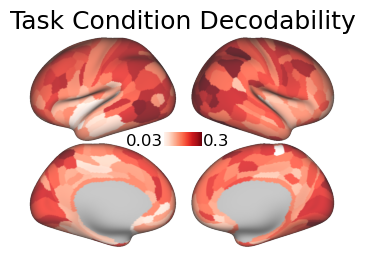

In [12]:
file_out = 'mean_taskCond_decodability'
inputdata = mean_taskCond_decodability
title = 'Task Condition Decodability'

get_brain_plot(inputdata,file_out,title,ignore_zero=False)

pixdim[1,2,3] should be non-zero; setting 0 dims to 1

Info: Time to read /tmp/HumanCorticalParcellations/S1200.L.flat.32k_fs_LR.surf.gii was 0.045502 seconds.


Info: Time to read /tmp/HumanCorticalParcellations/S1200.L.inflated_MSMAll.32k_fs_LR.surf.gii was 0.018606 seconds.


Info: Time to read /tmp/HumanCorticalParcellations/S1200.L.midthickness_MSMAll.32k_fs_LR.surf.gii was 0.02868 seconds.


Info: Time to read /tmp/HumanCorticalParcellations/S1200.L.very_inflated_MSMAll.32k_fs_LR.surf.gii was 0.01739 seconds.


Info: Time to read /tmp/HumanCorticalParcellations/S1200.R.flat.32k_fs_LR.surf.gii was 0.044178 seconds.


Info: Time to read /tmp/HumanCorticalParcellations/S1200.R.inflated_MSMAll.32k_fs_LR.surf.gii was 0.018436 seconds.


Info: Time to read /tmp/HumanCorticalParcellations/S1200.R.midthickness_MSMAll.32k_fs_LR.surf.gii was 0.028531 seconds.


Info: Time to read /tmp/HumanCorticalParcellations/S1200.R.very_inflated_MSMAll.32k_fs_LR.surf.gii was 0.017196 seconds.


Info: T

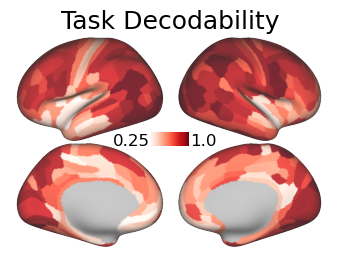

In [13]:
file_out = 'mean_tasksplit_decodability'
inputdata = mean_tasksplit_decodability
title = 'Task Decodability'

get_brain_plot(inputdata,file_out,title,ignore_zero=False)

In [39]:
# Brainsmash statistical testing

def brainsmash_perumtation_maxT(data,n_surrogates=1000):

    np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

    geo_dist_rh = np.loadtxt(helpfiles_dir + 'RightParcelGeodesicDistmat.txt')
    geo_dist_lh = np.loadtxt(helpfiles_dir + 'LeftParcelGeodesicDistmat.txt')
    base = Base(data[:180],geo_dist_lh)
    surrogates_lh = base(n=n_surrogates)
    base = Base(data[180:],geo_dist_rh)
    surrogates_rh = base(n=n_surrogates)
    surrogates_data = np.hstack((surrogates_lh,surrogates_rh))

    print('surrogates_data shape:',surrogates_data.shape)

    maxT_null_dist = np.max(surrogates_data,axis=1)

    p_data = np.zeros(nParcels)
    for reg_idx in range(nParcels):
        p_data[reg_idx] = np.sum(maxT_null_dist > data[reg_idx])/1000

    return p_data

## Checking dim_diff vs decodability correlation

In [10]:
# Representational dimensionality
with open(subProjDir + 'allsub_dimensionality_activeVisual_observed_18sub.pkl', 'rb') as f:
    allsub_obs_dimensionality = pickle.load(f)
print('allsub_obs_dimensionality shape:', allsub_obs_dimensionality.shape)

allsub_obs_dimensionality shape: (18, 360)


In [11]:
meansub_obs_dimensionality = np.mean(allsub_obs_dimensionality,axis=0)

In [12]:
taskCond_decodability_vs_dim_r,_ = stats.pearsonr(mean_taskCond_decodability,meansub_obs_dimensionality)
print('taskCond_decodability_vs_dim_r:',taskCond_decodability_vs_dim_r)

taskCond_decodability_vs_dim_r: 0.7547997706219415


In [13]:
tasksplit_decodability_vs_dim_r,_ = stats.pearsonr(mean_tasksplit_decodability,meansub_obs_dimensionality)
print('tasksplit_decodability_vs_dim_r:',tasksplit_decodability_vs_dim_r)

tasksplit_decodability_vs_dim_r: 0.78015318994908


In [23]:
# Brainsmash surrogates of dimensionality

np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

data = meansub_obs_dimensionality
n_surrogates = 1000

geo_dist_rh = np.loadtxt(helpfiles_dir + 'RightParcelGeodesicDistmat.txt')
geo_dist_lh = np.loadtxt(helpfiles_dir + 'LeftParcelGeodesicDistmat.txt')
base = Base(data[:180],geo_dist_lh)
surrogates_lh = base(n=n_surrogates)
base = Base(data[180:],geo_dist_rh)
surrogates_rh = base(n=n_surrogates)
surrogates_data = np.hstack((surrogates_lh,surrogates_rh))

In [31]:
geo_dist_rh.shape

(180, 180)

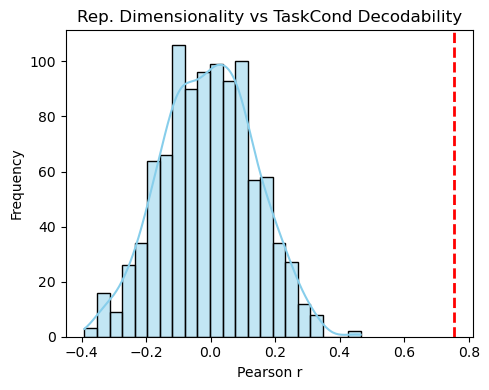

In [29]:
# Stats for comparison against task condition decodability

null_r = np.zeros(1000)
for surrogate_idx in range(n_surrogates):

    y = surrogates_data[surrogate_idx,:]
    null_r[surrogate_idx],_ = stats.pearsonr(mean_taskCond_decodability,y)
    
fig, axes = plt.subplots(figsize=(5, 4))

sns.histplot(null_r, kde=True, color='skyblue', ax=axes)
axes.axvline(x=taskCond_decodability_vs_dim_r, color='red', linestyle='--', linewidth=2)
axes.set_title(f'Rep. Dimensionality vs TaskCond Decodability')
axes.set_xlabel('Pearson r')
axes.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

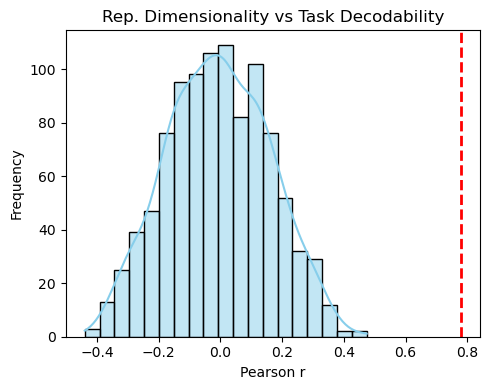

In [30]:
# Stats for comparison against task decodability

null_r = np.zeros(1000)
for surrogate_idx in range(n_surrogates):

    y = surrogates_data[surrogate_idx,:]
    null_r[surrogate_idx],_ = stats.pearsonr(mean_tasksplit_decodability,y)
    
fig, axes = plt.subplots(figsize=(5, 4))

sns.histplot(null_r, kde=True, color='skyblue', ax=axes)
axes.axvline(x=tasksplit_decodability_vs_dim_r, color='red', linestyle='--', linewidth=2)
axes.set_title(f'Rep. Dimensionality vs Task Decodability')
axes.set_xlabel('Pearson r')
axes.set_ylabel('Frequency')

plt.tight_layout()
plt.show()